In [2]:
import alpaca_trade_api as tradeapi
import time
from datetime import datetime, timedelta
import pytz 
tzUTC = pytz.timezone('UTC')
tzET = pytz.timezone('US/Eastern')
import math

import matplotlib.pyplot as plt
import matplotlib.dates as mdates # for formatting dates in graph
import pandas as pd
import numpy as np
import pylab as pl # for line segments
from matplotlib import collections  as mc

In [3]:
# def getKeys(): # todo need this later
#   pub = 'XXX'
#   sec = 'XXX'
#   url = 'https://paper-api.alpaca.markets' # in production remove 'paper-'
#   return pub, sec, url

In [4]:
# returns public and secure key from alpaca and paper trading url
# these should really be stored securely in a different file
def getKeys():
  pub = 'PKJ0P4P4I3IKN3EM29U0'
  sec = 'x3FGUvHqQEGCHHAClL10O3C6Ywo6NGgmbwXtBmwp'
  url = 'https://paper-api.alpaca.markets' # in production remove 'paper-'
  return pub, sec, url

In [5]:
# starts up alpaca account and prints the portfolio cash
def initAlpaca():
  global api

  import alpaca_trade_api as tradeapi
  import websocket

  # START UP ACCOUNT
  public, secret, url = getKeys()
  api = tradeapi.REST(public, secret, url, api_version='v2')
  account = api.get_account()
  assert(account.status == 'ACTIVE')
  print('cash = ' + account.cash)

In [6]:
# gets minute bars/candles for the stock with specific symbol between two iso dates
def getBarsForStockBetween(symbol, startIso, endIso):
  return api.get_barset(
    symbol, 
    'minute',
    start=startIso,
    end=endIso,
  )[symbol]

In [7]:
def roundDown(input, dp):
  factor = 10 ** dp
  return math.floor(input * factor)/factor

def roundUp(input, dp):
  factor = 10 ** dp
  return math.ceil(input * factor)/factor

In [8]:
def printColorMap(initialCash, totals, symbol, minSize, startIso, endIso):
  fig, ax = plt.subplots(figsize=(6, 6))
  
  labelIndices = []
  labels = []

  matrixNP = np.array(totals)
  ax.matshow(matrixNP, cmap=plt.cm.Blues)
  for i in range(len(totals)):
    labelIndices.append(i)
    labels.append(minSize + i)
    for j in range(len(totals)):
      ax.text(
        i, j, 
        str(roundUp(100*(matrixNP[j,i]-initialCash)/initialCash, 2)), 
        va='center', ha='center'
      )
  plt.title('Interest for stock: ' + symbol + ' between: ' + startIso + ' and ' + endIso + '\n'\
          'Buying on the first green after "Red run" reds and selling after the ' +\
          'first red after "Green run" greens')
  plt.xlabel('Green run (needed for selling)')
  plt.ylabel('Red run (needed for buying)')
  
  ax.set_xticks(labelIndices)
  ax.set_yticks(labelIndices)
  ax.set_xticklabels(labels)
  ax.set_yticklabels(labels)

  plt.show()

In [9]:
def applyStrategyCandles(bars, initialCash, runLimitRed, runLimitGreen):

  cash = initialCash # the spare "spending" money
  assets = 0 # what all shares are worth
  total = cash + assets # sum of cash and assets
  runRed = 0   # number of red   candles that have appeared in a row
  runGreen = 0 # number of green candles that have appeared in a row
  qty = 1 # the max quantity of shares to have at any time starts at 1 # todo set qty so that assets < 0.5*totals
  isStockBought = False

  priceBuy  = 0
  priceStop = 0

  # listBuyTime = []
  # listBuyPrice = []
  # listBuyStop = []

  priceLinesList = [] # start end priceBuy priceStop 
  priceLinesRow = [0, 0, 0, 0]
  
  profitLinesList = [] # time priceBuy priceProfit
  listTotals = [] # time total priceBlind

  # make the blind investment
  priceBlind = initialCash
  buyBlind = bars[0].c

  # print('len(bars) = ' + str(len(bars)))
  for bar in bars:

    isGreen = bar.c > bar.o
    isRed = bar.o > bar.c
    isDoji = not isGreen and not isRed

    # buy when: candle turns green after 3 or more red
    if not isStockBought:
      if runRed >= runLimitRed:
        if isGreen:
          # print('BUYING after 3 bears')

          # set qty so that assets < 0.5*totals
          qty = math.floor(total / bar.c)
          if qty == 0:
            print('You cant buy a share lol...')

          priceBuy = bar.c
          cost = qty * priceBuy
          cash -= cost
          if cash < 0:
            print('***BROKE*** ):')
            break

          assets += cost

          # note total stays the same
          
          priceStop = priceBuy * (1 - 0.005) # todo
          # print('  priceStop = ' + str(priceStop))
          isStockBought = True
          
          # for plotting
          priceLinesRow = [(bar.t).astimezone(tzET), 0, priceBuy, priceStop]
            
    # sell at the stop price
    if isStockBought:
      if bar.l < priceStop:
        # print('SELLING at stop price')

        cash += qty * priceStop
        assests = 0
        total = cash + assests

        isStockBought = False

        priceLinesRow[1] = (bar.t).astimezone(tzET)
        priceLinesList.append(priceLinesRow)
        priceLinesRow = [0, 0, 0, 0]

        profitLinesList.append([(bar.t).astimezone(tzET), priceBuy, priceStop])
      
      elif isRed and runGreen >= runLimitGreen and bar.c > priceBuy:
        # sell for profit when: candle turns red after 3 or more green and not a loss
        # print('SELLING after 3 bulls')
        
        cash += qty * bar.c
        assests = 0
        total = cash + assests

        # profit = qty * (bar.c - priceBuy)
        # total = cash + profit
        
        isStockBought = False

        priceLinesRow[1] = (bar.t).astimezone(tzET)
        priceLinesList.append(priceLinesRow)
        # priceLinesList.append([
        #   (bar.t).astimezone(tzET),
        #   (bar.t).astimezone(tzET),
        #   priceBuy,
        #   bar.c
        # ])
        priceLinesRow = [0, 0, 0, 0]

        profitLinesList.append([(bar.t).astimezone(tzET), priceBuy, bar.c])
      
      else:
        # if no sold, increase the portfolio total (also run after buying but makes no difference)

        assests = qty * bar.c
        total = cash + assests

        # for plotting 
        # listBuyTime.append((bar.t))
        # listBuyPrice.append(priceBuy)
        # listBuyStop.append(priceStop)
    

    # change run counts
    if isRed:
      runRed += 1
      runGreen = 0
    if isGreen:
      runGreen += 1
      runRed = 0

    priceBlind = initialCash * bar.c / buyBlind
    listTotals.append([(bar.t).astimezone(tzET), total, priceBlind])
    # print()

  # print('priceLinesList = ' + str(priceLinesList))
  # if the last shares have not been sold
  if isStockBought:
    priceLinesRow[1] = (bars[-1].t).astimezone(tzET)
    priceLinesList.append(priceLinesRow)
    # priceLinesRow = [0, 0, 0, 0] # todo not needed

  priceLinesDF = pd.DataFrame(priceLinesList, columns=['start', 'end', 'priceBuy', 'priceStop'])
  profitLinesDF = pd.DataFrame(profitLinesList, columns=['time', 'priceBuy', 'priceProfit'])
  totalsDF = pd.DataFrame(listTotals, columns=['time', 'total', 'priceBlind'])
  return priceLinesDF, profitLinesDF, totalsDF, total

In [10]:
def candlePlot(bars, priceLinesDF, profitLinesDF, totalsDF, initialCash):
  # Plotting
  fig, ax = plt.subplots(2, sharex=True, figsize=(14, 7))
  
  # blue is the investment on candle patterns
  ax[0].plot(totalsDF.time, totalsDF.total, color='b') 
  
  # black is the blind investment
  ax[0].plot(totalsDF.time, totalsDF.priceBlind, color='k')
  
  # green is for no investment
  ax[0].plot([totalsDF.time[0], list(totalsDF.time)[-1]], [initialCash, initialCash], color='green')

  
  listTimestamp = [] # todo change to listDates
  listOpen = []
  listClose = []
  listHigh = []
  listLow = []

  
  for b in bars:
    listTimestamp.append((b.t).astimezone(tz=tzET))
    listOpen.append(b.o)
    listClose.append(b.c)
    listHigh.append(b.h)
    listLow.append(b.l)

  isDrawingCandles = True
  if isDrawingCandles:
    # prices 317.9 # todo remove timing code

    prices = pd.DataFrame(index=listTimestamp)
    prices['Open'] = listOpen
    prices['High'] = listHigh
    prices['Low'] = listLow
    prices['Close'] = listClose

    pricesup=prices[prices.Close>=prices.Open]
    pricesdown=prices[prices.Close<prices.Open]

    width=0.9  * (1 / prices.shape[0]) / 20
    width2=0.1  * (1 / prices.shape[0]) / 30
    
    # plot the candles
    # green
    greenBarheight = [] # bar has a minimum thickness to ensure it shows up
    for index, row in pricesup.iterrows():
      height = row.Close - row.Open
      if height < 0.01 and height > -0.01:
        height = 0.01
      greenBarheight.append(height)
    ax[1].bar(pricesup.index, greenBarheight, width, bottom=pricesup.Open, color='g')
    ax[1].bar(pricesup.index, pricesup.High - pricesup.Low, width2, bottom=pricesup.Low, color='g')
    # red
    redBarheight = []
    for index, row in pricesdown.iterrows():
      height = row.Close - row.Open
      if height < 0.01 and height > -0.01:
        height = 0.01
      redBarheight.append(height)
    ax[1].bar(pricesdown.index, redBarheight, width, bottom=pricesdown.Open, color='r')
    ax[1].bar(pricesdown.index, pricesdown.High - pricesdown.Low, width2, bottom=pricesdown.Low, color='r')
    

    # plot the buy stop lines
    # buyStopDict = {'Timestamp':listBuyTime, 'priceBuy':listBuyPrice, 'priceStop':listBuyStop}
    # buyStopDF = pd.DataFrame(buyStopDict, columns=['Timestamp', 'priceBuy', 'priceStop'])
    # buyStopDF.priceBuy.plot(ax=ax, color='b')
    # buyStopDF.priceStop.plot(ax=ax, color='k')
    # buyStopDF.plot(x='Timestamp', y='priceBuy', ax=ax)
    # ax.plot(buyStopDF.Timestamp, buyStopDF.priceBuy)
    # plt.plot(buyStopDF.index, buyStopDF.priceBuy)
    # plt.plot(buyStopDF.index, buyStopDF.priceStop)
    # buyStopDF.priceStop.plot(ax=ax, color='k')
    
    # plt.plot([
    #   datetime(2020, 1, 2, 9, 30, 0, tzinfo=tzET),
    #   datetime(2020, 1, 2, 10, 30, 0, tzinfo=tzET)
    # ], [207, 207])
    # print('priceLinesDF = ')
    # print(priceLinesDF)
    # print()

  isDrawingProfitSymbols = True
  if isDrawingProfitSymbols:
    

    # print('str([row.start, row.end]) in each row = ')
    for index, row in priceLinesDF.iterrows():
      # print(str([row.start, row.end]))
      ax[1].plot([row.start, row.end], [row.priceBuy, row.priceBuy], color='b')
      ax[1].plot([row.start, row.end], [row.priceStop, row.priceStop], color='orange')
    
    for index, row in profitLinesDF.iterrows():
      ax[1].plot([row.time, row.time], [row.priceBuy, row.priceProfit], color='b')
    
    

  
  # max 40 ticks
  listDatesForTicks = []
  if len(listTimestamp) > 40:
    tickFreq = roundUp(len(listTimestamp) / 40, 0)
    for i, date in enumerate(listTimestamp):
      if i % tickFreq == 0:
        listDatesForTicks.append(date)
  else:
    listDatesForTicks = listTimestamp
  plt.xticks(listDatesForTicks)

  ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %I:%M %p'))
  plt.xticks(rotation=90)
  # fig.subplots_adjust(bottom=0.2)
  fig.tight_layout()
  # ax.set_xticklabels(OX_ticks_name, rotation=90, horizontalalignment='left', fontsize=10)

  
  plt.grid()
  plt.show()


In [11]:
def viewBullsBears(startIso, endIso):

  # financial inputs
  initialCash = 10000
  runLimitRed = 0 # how many bears/reds are needed before a buy
  runLimitGreen = 0 # how many bulls/greens are needed before a sell
  symbol = 'FB'

  
  
  bars = getBarsForStockBetween(symbol, startIso, endIso)

  totals = []
  minSize = 2
  maxSize = 8
  graphLimitRed   = 3
  graphLimitGreen = 3
  
  priceLinesDF_3Red3Green = None
  profitLinesDF_3Red3Green = None
  totalsDF_3Red3Green = None
  
  for runLimitRed in range(minSize, maxSize + 1): # red is on the vertical axis
    totalsRow = []
    for runLimitGreen in range(minSize, maxSize + 1):
      if len(bars) > 0:
        priceLinesDF, profitLinesDF, totalsDF, total = applyStrategyCandles(bars, initialCash, runLimitRed, runLimitGreen)
        if(runLimitRed == graphLimitRed and runLimitGreen == graphLimitGreen):
          priceLinesDF_3Red3Green  = priceLinesDF
          profitLinesDF_3Red3Green = profitLinesDF
          totalsDF_3Red3Green      = totalsDF
      else:
        print('ERROR: '+ symbol + ' has no bars !')
        return 0
      totalsRow.append(total)
    
#     print('totalsRow = ' + str(totalsRow))
    totals.append(totalsRow)
  
  printColorMap(initialCash, totals, symbol, minSize, startIso, endIso)
  
  if not priceLinesDF_3Red3Green.empty:
    candlePlot(bars, priceLinesDF_3Red3Green, profitLinesDF_3Red3Green, totalsDF_3Red3Green, initialCash)

cash = 99985.8


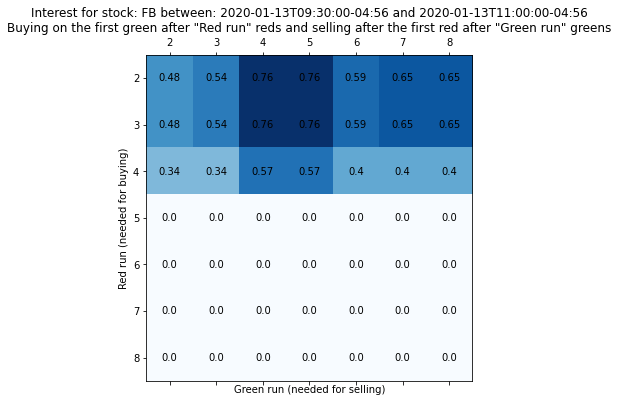

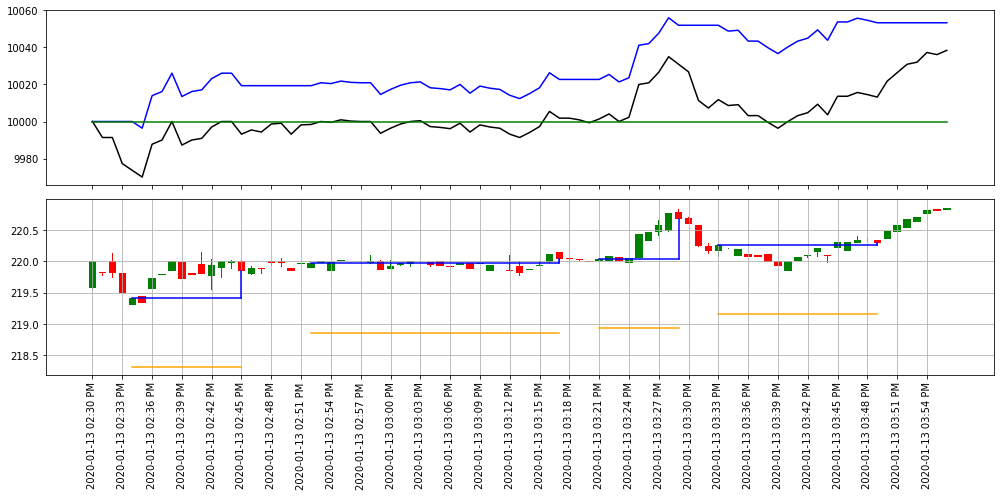

In [12]:
initAlpaca()
viewBullsBears(
  datetime(2020, 1, 13,  9, 30, 0, tzinfo=tzET).isoformat(),
  datetime(2020, 1, 13, 11, 0, 0, tzinfo=tzET).isoformat()
)

cash = 99985.8


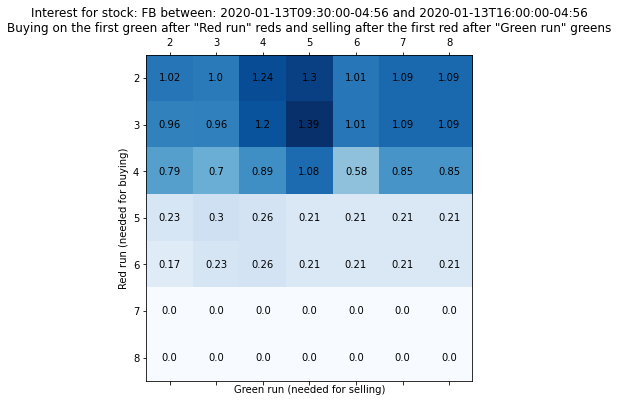

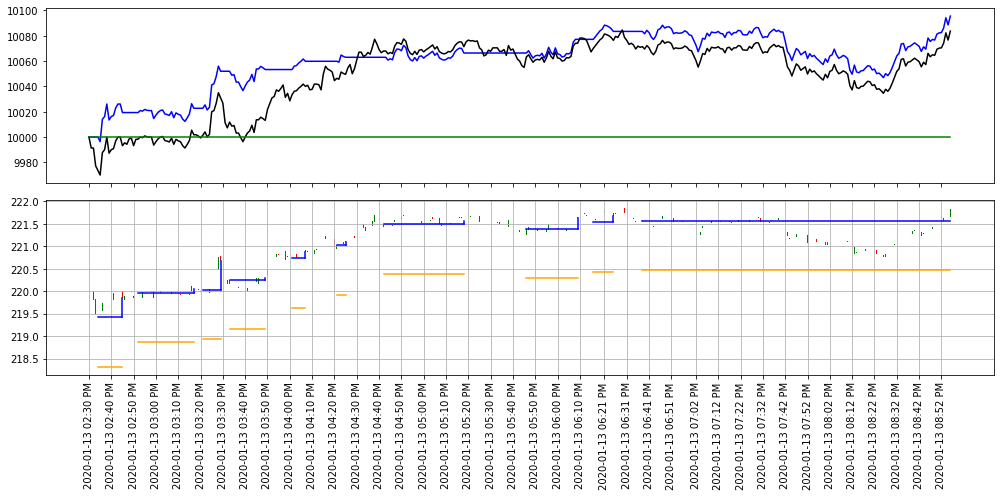

In [28]:
initAlpaca()
viewBullsBears(
  datetime(2020, 1, 13, 9, 30, 0, tzinfo=tzET).isoformat(),
  datetime(2020, 1, 13, 16, 0, 0, tzinfo=tzET).isoformat()
)

cash = 99985.8


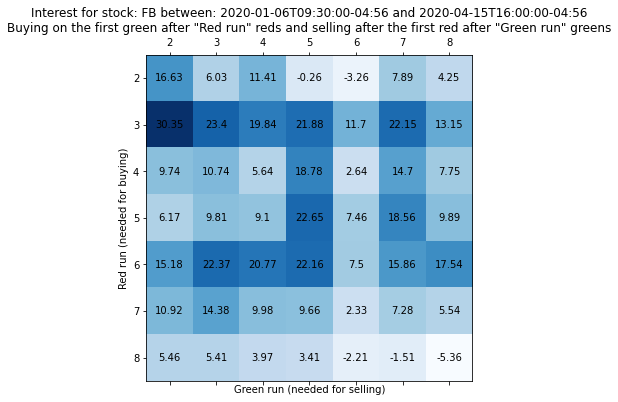

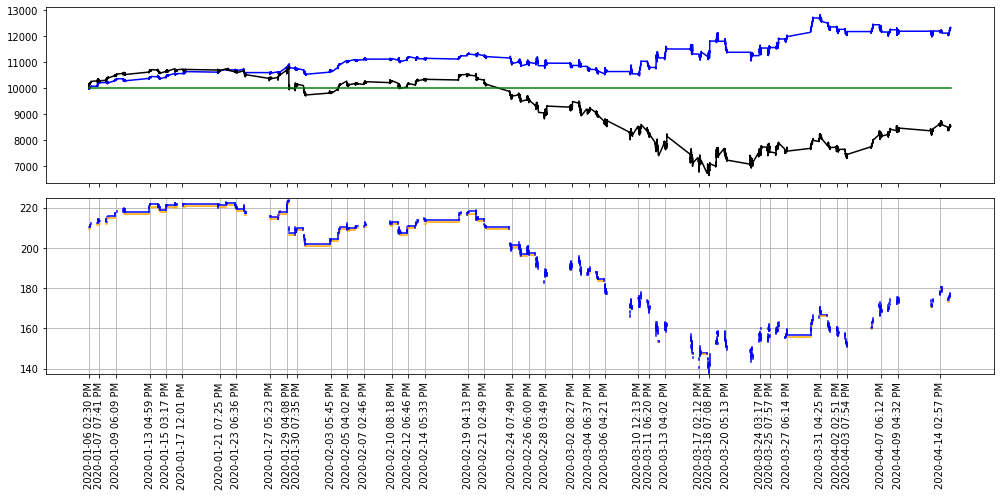

In [24]:
initAlpaca()
viewBullsBears(
  datetime(2020, 1,  6, 9, 30, 0, tzinfo=tzET).isoformat(),
  datetime(2020, 4, 15, 16, 0, 0, tzinfo=tzET).isoformat()
)